In [30]:
!pip install --upgrade pip
!pip install pyathena

In [31]:
#Upgrade de la version de seaborn para poder hacer graficos mas facil 
!pip install seaborn==0.12.2

In [32]:
#Libraries
from pyathena import connect
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer 

In [33]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'analytics'
tablaSource = 'source_fraud_fechas_label'


In [568]:
#Connection

conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
#date_to_compare1 = '2023-01-01'
#date_to_compare2 = '2023-05-01'
#Pongo el mes para el que traigo los datos y para poenr en el nombre del parquet
mes_data = '202312'
#Pongo uno si quiero generar los datos para el test
archivo_test = 1

df_source = pd.read_sql('''SELECT * FROM analytics.source_fraud_fechas_label 
            where date_receiver_clean between cast('2023-12-01'  as date) and cast('2024-01-01'  as date);''', conn)


/tmp/ipykernel_45076/340747501.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_source = pd.read_sql('''SELECT * FROM analytics.source_fraud_fechas_label


In [569]:
#df_source2 = pd.read_sql('''SELECT * FROM analytics.source_fraud_fechas_label 
#             where date_receiver_clean between cast('2023-01-01'  as date) and cast('2023-01-15'  as date);''', conn)


In [570]:
df_source.head()

,id_branch,id_receiver,date_receiver,hour_receiver,day_name_receiver,net_amount_receiver,id_payout,was_fraud,was_fraud_pattern,was_ofac_receiver_hit,...,id_payer,id_sender_global,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_to_last_transaction,day,date_receiver2,id_sender2,fraud_type,date_receiver_clean
0,A06978,25356,2023-12-10 17:04:13.377000000,17,Sunday,520.0,P,0,0,0,...,T331,10828091,9136,1344,17,2023-12-10,2023-12-10 17:04:13.377,960.0,None,2023-12-10
1,A16784,127945,2023-12-10 16:57:16.353000000,16,Sunday,100.0,C,0,0,0,...,T109,11045293,12722,4,20,2023-12-10,2023-12-10 16:57:16.353,15323.0,None,2023-12-10
2,A25461,1046,2023-12-10 16:57:44.280000000,16,Sunday,70.0,P,0,0,0,...,T085,11066486,11503,11,20,2023-12-10,2023-12-10 16:57:44.280,508.0,None,2023-12-10
3,A19661,5533,2023-12-10 17:01:27.957000000,17,Sunday,250.0,P,0,0,0,...,T152,6625720,28899,1316,12,2023-12-10,2023-12-10 17:01:27.957,682.0,None,2023-12-10
4,A18458,119133,2023-12-10 16:59:07.130000000,16,Sunday,142.0,C,0,0,0,...,T131,7628962,31799,2,0,2023-12-10,2023-12-10 16:59:07.130,7314.0,None,2023-12-10


In [571]:
df_source['mes'] = df_source['date_receiver_clean'].dt.month
df_source['fraud_type'] = df_source['fraud_type'].str.capitalize()

## Defino funciones para los datos
### creo_dummies y escalo_percentiles

In [572]:
#defino funcion para normalizar
def escalo_percentiles(data, Pmin, Pmax):
    #Escalo por Quartiles
    Qmin = Pmin
    Qmax = Pmax

    m = data.min()
    M = data.max()
    q0 = data.quantile(Qmin)
    q1 = data.quantile(Qmax)

    data_std = (data - q0) / (q1 - q0)
    dataN =  data_std.to_numpy()
    #Pongo los outliers con un maximo
    dataN = np.clip(dataN,0,1)
    return dataN

In [573]:
#creo dummies a partir de la lista de variables
def creo_dummies(df, todummy_list):
    df0 = df.copy()
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, axis = 1)
        df = pd.concat([df, dummies], axis=1)
        df = pd.DataFrame(df)
    return df, df.columns.difference(df0.columns)

## Creo las nuevas variables
### sender_days_to_last_transaction_365 y sender_days_to_last_transaction_more365
### sender_minutes_since_last_transaction_2days
### net_amount_receiver?

In [574]:
#defino corte en funcion deñ percenti
df_source['sender_days_to_last_transaction'].describe()

count    2.604149e+06
mean     6.371867e+00
std      8.374923e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.300000e+01
max      3.000000e+01
Name: sender_days_to_last_transaction, dtype: float64

In [575]:
#defino dos nuevas variables a partir de la anterior
df_source['sender_days_to_last_transaction_365'] = df_source['sender_days_to_last_transaction']
df_source['sender_days_to_last_transaction_more365'] = 0
#corto en un maximo de dias y el resto lo pongo enlas variables nuevas
df_source.sender_days_to_last_transaction_more365[df_source['sender_days_to_last_transaction']> 365] = 1
df_source.sender_days_to_last_transaction_365[df_source['sender_days_to_last_transaction']> 365] = 0 

/tmp/ipykernel_45076/461507757.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_source.sender_days_to_last_transaction_more365[df_source['sender_days_to_last_transaction']> 365] = 1
/tmp/ipykernel_45076/461507757.py:5: SettingWithCopyW

In [576]:
#defino dos nuevas variables a partir de la anterior
df_source['sender_minutes_since_last_transaction_2days'] = df_source['sender_minutes_since_last_transaction']
df_source['sender_minutes_since_last_transaction_1day'] = df_source['sender_minutes_since_last_transaction']
#corto en un maximo de dias y el resto lo pongo enlas variables nuevas
df_source.sender_minutes_since_last_transaction_2days[df_source['sender_minutes_since_last_transaction']> 2*24*60] = 0
df_source.sender_minutes_since_last_transaction_1day[df_source['sender_minutes_since_last_transaction']> 24*60] = 0

/tmp/ipykernel_45076/2804084275.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_source.sender_minutes_since_last_transaction_2days[df_source['sender_minutes_since_last_transaction']> 2*24*60] = 0
/tmp/ipykernel_45076/2804084275.py:5: 

## Estandarizo variables
### sender_days_to_last_transaction_365, sender_minutes_since_last_transaction_2days, net_amount_receiver, sender_sending_days, branch_working_days, receiver_transaction_count

In [577]:
df_source['receiver_transaction_count'].describe()

count    2.604149e+06
mean     1.315600e+01
std      1.980524e+01
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.600000e+01
max      6.660000e+02
Name: receiver_transaction_count, dtype: float64

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='01_receiver_transaction_count', ylabel='Count'>

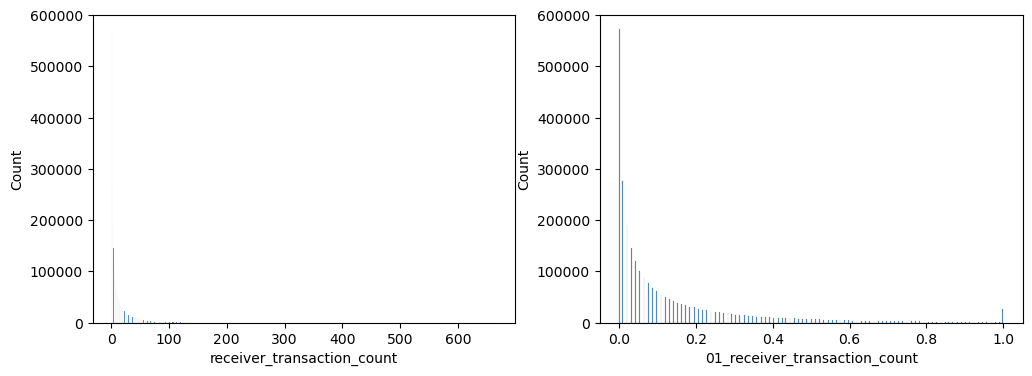

In [578]:
df_source['01_receiver_transaction_count'] = escalo_percentiles(df_source['receiver_transaction_count'], 0.01, 0.99)
fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="receiver_transaction_count", ax = axs[0])
sns.histplot(data=df_source, x="01_receiver_transaction_count", ax = axs[1])

In [579]:
df_source['sender_sending_days'].describe()

count    2.604149e+06
mean     3.996472e+02
std      2.583425e+02
min      0.000000e+00
25%      1.500000e+02
50%      4.260000e+02
75%      6.710000e+02
max      7.290000e+02
Name: sender_sending_days, dtype: float64

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='01_sender_sending_days', ylabel='Count'>

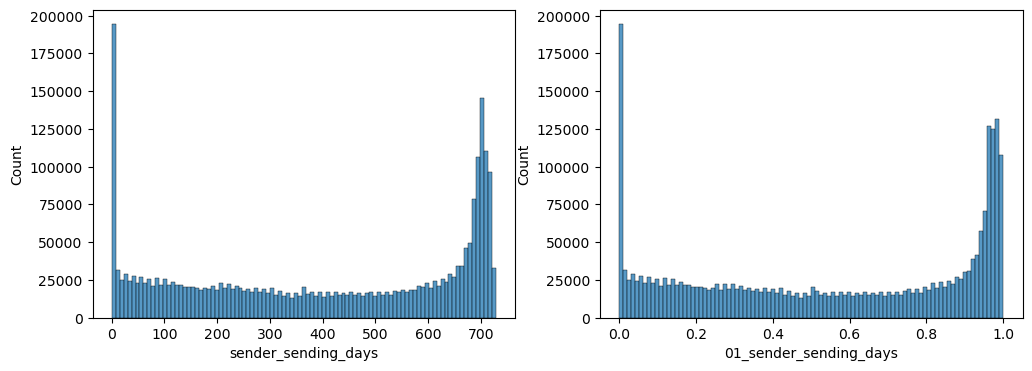

In [580]:
df_source['01_sender_sending_days'] = escalo_percentiles(df_source['sender_sending_days'], 0.01, 0.99)

fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="sender_sending_days", ax = axs[0])
sns.histplot(data=df_source, x="01_sender_sending_days", ax = axs[1])

In [581]:
df_source['branch_working_days'].describe()

count    2.604149e+06
mean     1.604585e+03
std      1.400196e+03
min     -1.000000e+00
25%      5.530000e+02
50%      1.282000e+03
75%      2.192000e+03
max      6.900000e+03
Name: branch_working_days, dtype: float64

In [582]:
df_source['net_amount_receiver'].describe()

count    2.604149e+06
mean     4.374798e+02
std      5.460078e+02
min      0.000000e+00
25%      1.030000e+02
50%      2.300000e+02
75%      5.000000e+02
max      7.995000e+03
Name: net_amount_receiver, dtype: float64

In [583]:
df_source['sender_minutes_since_last_transaction_2days'].describe()

count    2.604149e+06
mean     1.035603e+02
std      4.406644e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.880000e+03
Name: sender_minutes_since_last_transaction_2days, dtype: float64

In [584]:
df_source['sender_minutes_since_last_transaction_1day'].describe()

count    2.604149e+06
mean     2.936823e+01
std      1.826301e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.440000e+03
Name: sender_minutes_since_last_transaction_1day, dtype: float64

In [585]:
df_source['sender_days_to_last_transaction_365'].describe()

count    2.604149e+06
mean     6.371867e+00
std      8.374923e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.300000e+01
max      3.000000e+01
Name: sender_days_to_last_transaction_365, dtype: float64

In [586]:
df_source['branch_minutes_since_last_transaction'].describe()

count    2.604149e+06
mean     9.364731e+01
std      6.648169e+02
min      0.000000e+00
25%      3.000000e+00
50%      9.000000e+00
75%      2.900000e+01
max      3.989780e+05
Name: branch_minutes_since_last_transaction, dtype: float64

In [587]:
# Normalizo a lo bruto. Dsp reviso el algoritmo
df_source['01_receiver_transaction_count'] = escalo_percentiles(df_source['receiver_transaction_count'], 0.01, 0.99)
df_source['01_branch_working_days'] = escalo_percentiles(df_source['branch_working_days'], 0.01, 0.99)
df_source['01_net_amount_receiver'] = escalo_percentiles(df_source['net_amount_receiver'], 0.01, 0.99)
df_source['01_sender_minutes_since_last_transaction_2days'] = escalo_percentiles(df_source['sender_minutes_since_last_transaction_2days'], 0.01, 0.99)
df_source['01_sender_minutes_since_last_transaction_1day'] = escalo_percentiles(df_source['sender_minutes_since_last_transaction_1day'], 0.01, 0.99)
df_source['01_sender_days_to_last_transaction_365'] = escalo_percentiles(df_source['sender_days_to_last_transaction_365'], 0.01, 0.99)


In [588]:
df_source['01_receiver_transaction_count'].describe()
df_source['01_sender_sending_days'].describe()
df_source['01_branch_working_days'].describe()
df_source['01_net_amount_receiver'].describe()
df_source['01_sender_minutes_since_last_transaction_2days'].describe()
df_source['01_sender_minutes_since_last_transaction_1day'].describe()
df_source['01_sender_days_to_last_transaction_365'].describe()

count    2.604149e+06
mean     2.272762e-01
std      2.983299e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.642857e-01
max      1.000000e+00
Name: 01_sender_days_to_last_transaction_365, dtype: float64

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='01_sender_days_to_last_transaction_365', ylabel='Count'>

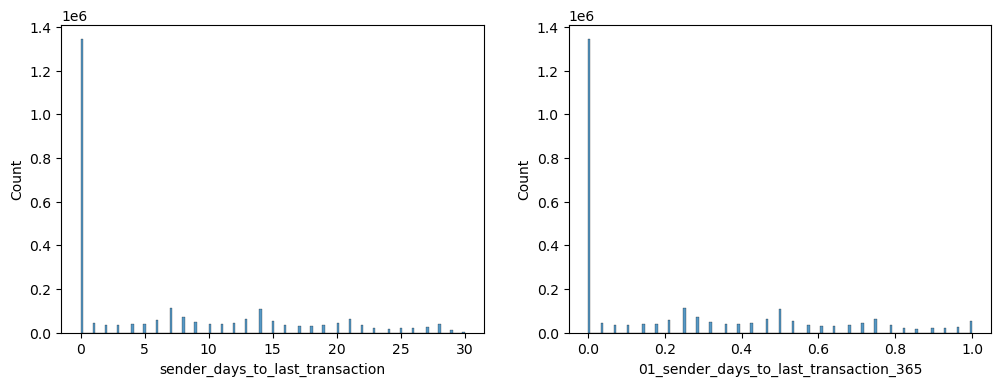

In [589]:
fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="sender_days_to_last_transaction", ax = axs[0])
sns.histplot(data=df_source, x="01_sender_days_to_last_transaction_365", ax = axs[1])

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


sender_days_to_last_transaction_more365
0    2604149
Name: count, dtype: int64

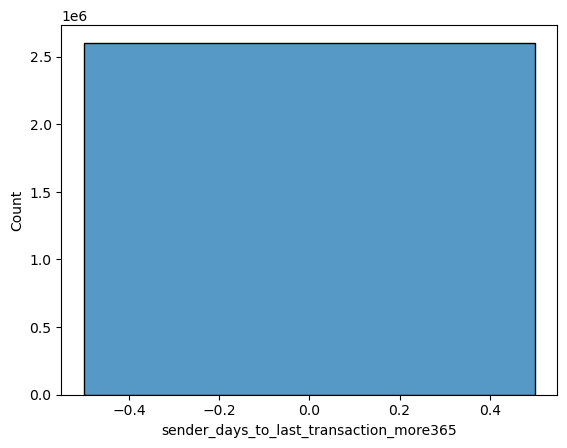

In [590]:
sns.histplot(data=df_source, x='sender_days_to_last_transaction_more365')
df_source['sender_days_to_last_transaction_more365'].value_counts()

## Creo Variables dummy

In [591]:
todummy_list = ['day_name_receiver','id_payout']
[df_source, var_nuevas] = creo_dummies(df_source, todummy_list)

## Creacion del target

In [592]:
df_source['fraud_type'].value_counts()

fraud_type
Payment    33
Name: count, dtype: int64

In [593]:
# defino los targets
df_source['target1'] = df_source['fraud_type'] == 'Remote access'
df_source['target2'] = df_source['fraud_type'] == 'Payment'
df_source['target_fraudes'] = df_source['fraud_type'].notnull()


In [594]:
df_source['target1'].value_counts()

target1
False    2604149
Name: count, dtype: int64

In [595]:
df_source['target2'].value_counts()

target2
False    2604116
True          33
Name: count, dtype: int64

In [596]:
df_source['target_fraudes'].value_counts()

target_fraudes
False    2604116
True          33
Name: count, dtype: int64

## Guardo archivos para dsp juntar en el entrenamiento

In [597]:
#Me quedo con las variables q voy a usar
df_source.columns.values
df = df_source [['id_branch','id_receiver','id_sender_global',
           '01_receiver_transaction_count','01_sender_sending_days','01_branch_working_days','01_net_amount_receiver','01_sender_minutes_since_last_transaction_2days',
           '01_sender_minutes_since_last_transaction_1day','01_sender_days_to_last_transaction_365','sender_days_to_last_transaction_more365']]
df = pd.concat([df, df_source[var_nuevas]], axis=1)
df = pd.concat([df, df_source[['target1','target2','target_fraudes']]], axis=1)

##'sender_days_since_last_transaction','sender_minutes_since_last_transaction'
#'id_branch', 'id_receiver', 'hour_receiver','day_name_receiver','net_amount_receiver','was_ofac_receiver_hit','was_ofac_sender_hit',
#'receiver_transaction_count','branch_working_days','sender_sending_days','branch_minutes_since_last_transaction','sender_days_to_last_transaction',
#'fraud_type','date_receiver_clean','target1','target2',

In [598]:
df

,id_branch,id_receiver,id_sender_global,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,...,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,target1,target2,target_fraudes
0,A06978,25356,10828091,0.065217,0.078947,0.735903,0.190661,0.0,0.0,0.607143,...,False,False,False,True,False,False,False,False,False,False
1,A16784,127945,11045293,0.054348,0.018006,0.343545,0.027237,0.0,0.0,0.714286,...,False,False,False,False,False,False,False,False,False,False
2,A25461,1046,11066486,0.000000,0.011080,0.000000,0.015564,0.0,0.0,0.714286,...,False,False,False,True,False,False,False,False,False,False
3,A19661,5533,6625720,0.402174,0.943213,0.203838,0.085603,0.0,0.0,0.428571,...,False,False,False,True,False,False,False,False,False,False
4,A18458,119133,7628962,0.086957,0.930748,0.253661,0.043580,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2604144,A22634,12681,10427618,0.043478,0.198061,0.091567,0.143969,0.0,0.0,0.000000,...,False,False,False,True,False,False,False,False,False,False
2604145,A07837,764,11011925,0.010870,0.033241,0.694833,0.256809,0.0,0.0,0.000000,...,False,False,False,True,False,False,False,False,False,False
2604146,A19725,22591,11119980,0.032609,0.000000,0.202659,0.027237,0.0,0.0,0.428571,...,False,False,False,True,False,False,False,False,False,False
2604147,A07311,34154,3648765,0.750000,0.961219,0.716883,0.105058,0.0,0.0,0.571429,...,False,False,False,True,False,False,False,False,False,False


In [599]:
import os
import pyarrow as pa
import pyarrow.parquet as pq

In [600]:
#guardar_dataset_con_valor_parquet(df_source, columna_nombre='mes', nombre_archivo='Prepoc_Fraude',carpeta='ABT') # save ABT in parquet format

In [601]:
if archivo_test == 0:
    s3_url = f"s3://viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Train/Preproc_Fr_{mes_data}.parquet"
elif archivo_test ==1:
    s3_url = f"s3://viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Test/Preproc_Fr_{mes_data}.parquet"
#df.to_parquet(path='./exp1.parquet', engine='pyarrow', compression='gzip')
df.to_parquet(path=s3_url, engine='pyarrow', compression='gzip')
print('termine de salvar el parquet')

termine de salvar el parquet


## Entreno para probar un minimodelo

In [602]:
#s3_url = f"s3://viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Train/Preproc_Fr_{mes_data}.parquet"
#df = pd.read_parquet(s3_url)

In [603]:
df.head(5)

,id_branch,id_receiver,id_sender_global,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,...,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,target1,target2,target_fraudes
0,A06978,25356,10828091,0.065217,0.078947,0.735903,0.190661,0.0,0.0,0.607143,...,False,False,False,True,False,False,False,False,False,False
1,A16784,127945,11045293,0.054348,0.018006,0.343545,0.027237,0.0,0.0,0.714286,...,False,False,False,False,False,False,False,False,False,False
2,A25461,1046,11066486,0.000000,0.011080,0.000000,0.015564,0.0,0.0,0.714286,...,False,False,False,True,False,False,False,False,False,False
3,A19661,5533,6625720,0.402174,0.943213,0.203838,0.085603,0.0,0.0,0.428571,...,False,False,False,True,False,False,False,False,False,False
4,A18458,119133,7628962,0.086957,0.930748,0.253661,0.043580,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False


In [604]:
#features = df[[
#           '01_receiver_transaction_count','01_sender_sending_days','01_branch_working_days','01_net_amount_receiver','01_sender_minutes_since_last_transaction_2days',
#           '01_sender_minutes_since_last_transaction_1day','01_sender_days_to_last_transaction_365',
#           'target_fraudes']]
#label = df['target_fraudes']
#size = 1759577

# Hold out 20% of the dataset for training

#test_size = int(np.round(size * 0.2, 0))# Split dataset into training and testing sets
#x_train = features[:-test_size].values
#y_train = label[:-test_size].values
#x_test = features[-test_size:].values
#y_test = label[-test_size:].values

In [605]:
#from sklearn import svm

#model = svm.SVC(kernel='poly', degree=2)
#model.fit(x_train, y_train)

In [606]:
#from sklearn.metrics import accuracy_score
#predictions_poly = model.predict(x_test)
#accuracy_poly = accuracy_score(y_test, predictions_poly)

In [607]:
#print("2nd degree polynomial Kernel\nAccuracy (normalized): " + str(accuracy_poly))

In [608]:
mes_data

'202312'